In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
from sklearn.cluster import KMeans
import random
import os


In [2]:

np.random.seed(18)
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
X = np.concatenate((X0, X1, X2), axis = 0)
K = 3 # 3 clusters
original_label = np.asarray([0]*N + [1]*N + [2]*N).T
print(X.shape)
# print(X0, X1, X2)
print(original_label)

(1500, 2)
[0 0 0 ... 2 2 2]


averageAreaContour: 1077.3
centerArray: [(341, 1054), (483, 1059), (458, 1059), (374, 1058), (424, 1059), (420, 1059), (400, 1058), (907, 942), (765, 936), (882, 941), (798, 940), (848, 941), (844, 942), (824, 940), (209, 737), (351, 742), (326, 742), (242, 741), (292, 742), (288, 742), (268, 741), (612, 611), (754, 617), (729, 616), (645, 615), (695, 616), (691, 616), (671, 615)]


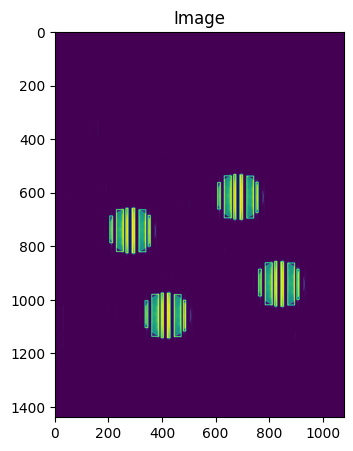

In [3]:
# img_path = "E:\Project\OOC\LEDs_Data_Processing\LED_Decode\led_image\LEDID_4_RoI_adjusted.jpg"
img_path ="E:\Project\OOC\LEDs_Data_Processing\LED_Decode\led_image\LEDID_4_RoI_batky.jpg"
# img_path = "E:\Project\OOC\LEDs_Data_Processing\LED_Decode\led_image\\2led.png"

img = plt.imread(img_path)
height, width = img.shape[:2]
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imageConvert = cv2.convertScaleAbs(image, alpha=255.0 / np.max(image))
_, threshold_imageConvert = cv2.threshold(
    imageConvert, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
contours, hierarchy = cv2.findContours(
    threshold_imageConvert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)


averageAreaContour = np.mean([cv2.contourArea(c) for c in contours])
print(f"averageAreaContour: {averageAreaContour}")
boundingBox = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area > averageAreaContour / 10:
        x, y, w, h = cv2.boundingRect(contour)
        boundingBox.append((x, y, w, h))
        cv2.rectangle(imageConvert, (x, y), (x + w, y + h), (255, 255, 0), 2)

centerArray = []
center_with_box_data = []
for box in boundingBox:
    x, y, w, h = box
    center = (x + w // 2, y + h // 2)
    centerArray.append(center)
print(f"centerArray: {centerArray}")

# print(f"centerArray: {centerArray}")
plt.figure(figsize=(5, 5))  # Adjust figure size as needed
plt.imshow(imageConvert)
plt.title("Image")
plt.show()

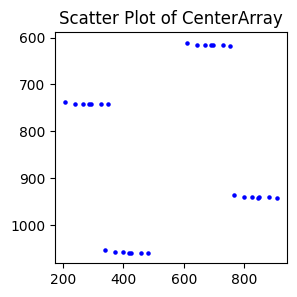

In [4]:
plt.figure(figsize=(3, 3))  # Adjust figure size as needed

# Create scatter plot
plt.scatter(*zip(*centerArray), marker="o", color="blue", s=5)

# Set title and axis labels
plt.title("Scatter Plot of CenterArray")
plt.xlabel("")
plt.ylabel("")
plt.gca().invert_yaxis()
plt.show()

In [5]:
def kmeans(data, k, max_iters):
    """Performs K-means clustering on data without using scikit-learn."""
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]  # Initial centroids

    for _ in range(max_iters):
        # Assign data points to closest centroid
        labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)

        # Update centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return labels

data = np.array(centerArray)
k = 4
max_iters = len(centerArray)

labels = kmeans(data, k, max_iters)
print(labels)

[0 0 0 0 0 0 0 2 2 2 2 2 2 2 3 3 3 3 3 3 3 1 1 1 1 1 1 1]


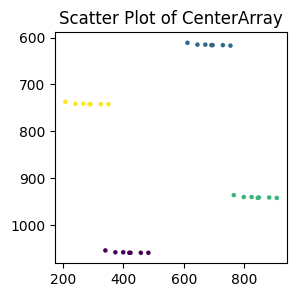

In [6]:
# kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(centerArray)
# print(kmeans)
plt.figure(figsize=(3, 3))  # Adjust figure size as needed
plt.scatter(*zip(*centerArray),c = labels, marker="o", s=5)

# Set title and axis labels

plt.title("Scatter Plot of CenterArray")
plt.xlabel("")
plt.ylabel("")
plt.gca().invert_yaxis()
plt.show()

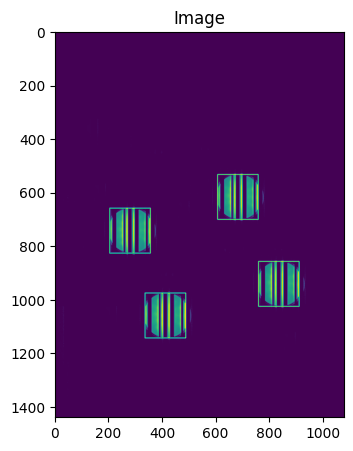

In [7]:
rois = []

for label in range(4):
        cluster_contours = [box for i, box in enumerate(boundingBox) if labels[i] == label]

        # Calculate ROI based on the contours in the cluster
        x_min = min(box[0] for box in cluster_contours)
        y_min = min(box[1] for box in cluster_contours)
        x_max = max(box[0] + box[2] for box in cluster_contours)
        y_max = max(box[1] + box[3] for box in cluster_contours)
        rois.append([x_min, y_min, x_max - x_min, y_max - y_min])
        
        # Draw rectangle around the LED
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 255, 0), 2)

plt.figure(figsize=(5, 5))  # Adjust figure size as needed
plt.imshow(image)
plt.title("Image")
plt.show()